# Unidad 2: Estructura de los datos en series de tiempo

## 2.1 Introducción

Dado que una serie de tiempo es un conjunto de observaciones sobre los valores que toma una variable (cuantitativa) a través del tiempo, exploraremos las tendencias o cambios que se reflejan y afectan su comportamiento.

## 2.2 Acción

Ahora, en esta Unidad 2, se debe continuar con los datos presentados en dicho entregable y se debe evidenciar, en una de las variables en el tiempo, la aproximación en promedio móvil, en rezagos y en estacionalidad. Todo lo anterior, a través de funciones y gráficas que permitan detectar patrones y ciclos de la variable.

### 2.2.1 Preparación de los datos

Previo al análisis detallado, es imperativo comprender el proceso de preparación de datos temporales para garantizar su idoneidad y coherencia en el estudio.

In [1]:
# importando librerias

# librerias para la transformación de datos
import pandas as pd
import numpy as np
from datetime import datetime
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

# libreria para visualización de datos
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# recopilación de datos
df_data = pd.read_csv('./dataset.csv',sep=';')
df_data.head()

,fechaoperacion,codigo,contenido,hora1,hora2,hora3,hora4,hora5,hora6,hora7,...,hora15,hora16,hora17,hora18,hora19,hora20,hora21,hora22,hora23,hora24
0,1/01/2006,PBNA,PRECIO DE BOLSA NACIONAL ($/KWH),87.778212,77.778212,77.778212,77.778212,77.778212,77.778212,75.768212,...,75.768212,71.278212,69.067212,76.278212,77.778212,87.778212,87.778212,77.778212,77.778212,77.778212
1,2/01/2006,PBNA,PRECIO DE BOLSA NACIONAL ($/KWH),76.278212,76.278212,76.278212,76.278212,76.278212,76.778212,76.778212,...,82.778212,82.778212,82.778212,81.768212,87.778212,87.778212,87.778212,82.778212,76.778212,76.778212
2,3/01/2006,PBNA,PRECIO DE BOLSA NACIONAL ($/KWH),77.678212,77.678212,77.678212,77.678212,77.678212,77.678212,77.678212,...,82.778212,82.778212,82.778212,82.778212,87.778212,114.425212,87.778212,82.778212,77.678212,77.678212
3,4/01/2006,PBNA,PRECIO DE BOLSA NACIONAL ($/KWH),77.778212,77.778212,77.778212,77.778212,77.778212,77.778212,77.778212,...,77.778212,77.778212,77.778212,85.778212,85.778212,87.778212,85.778212,85.778212,81.768212,77.778212
4,5/01/2006,PBNA,PRECIO DE BOLSA NACIONAL ($/KWH),86.778212,86.778212,86.778212,86.778212,86.778212,86.778212,88.278212,...,88.278212,88.278212,88.278212,88.278212,88.278212,91.134212,88.278212,88.278212,86.778212,86.778212


Se realiza una transformacion de los datos separandoos por año,mes,dia y periodo, esto con el fin de poder graficar y analizar mas detalladamente el dataset.

In [3]:
def trf_data(df_data):
    
    # copia del dataframe
    df = df_data.copy()
    
    # transformación de fechas
    df['fechaoperacion'] = pd.to_datetime(df['fechaoperacion'], format='%d/%m/%Y')
    
    # agregando las columnas de fechas
    df['ano'] = df.apply(lambda x: x['fechaoperacion'].year ,axis=1)
    df['mes'] = df.apply(lambda x: x['fechaoperacion'].month ,axis=1)
    df['dia'] = df.apply(lambda x: x['fechaoperacion'].day ,axis=1)
    
    # selección de columnas
    df = df[['fechaoperacion','ano','mes','dia', 'hora1', 'hora2', 'hora3','hora4', 'hora5', 'hora6', 'hora7', 'hora8', 'hora9', 'hora10','hora11', 'hora12', 'hora13', 'hora14', 'hora15', 'hora16', 'hora17','hora18', 'hora19', 'hora20', 'hora21', 'hora22', 'hora23', 'hora24']]
    
    # Convertir la tabla
    list_id = [i.lower() for i in df.columns if not 'hora' in i]
    list_value = [i.lower() for i in df.columns if 'hora' in i]
    
    # pivotear la tabla
    df = df.melt(id_vars=list_id,value_vars=list_value,var_name='periodo',value_name='valor')
    
    return df

In [4]:
# dataset trasnformado
df = trf_data(df_data)
df.head()

,fechaoperacion,ano,mes,dia,periodo,valor
0,2006-01-01,2006,1,1,hora1,87.778212
1,2006-01-02,2006,1,2,hora1,76.278212
2,2006-01-03,2006,1,3,hora1,77.678212
3,2006-01-04,2006,1,4,hora1,77.778212
4,2006-01-05,2006,1,5,hora1,86.778212


### 2.2.2 Análisis promedio movil

Adentrándonos en el análisis práctico, exploramos el concepto y la aplicación del promedio móvil, una herramienta para descifrar tendencias y patrones en series temporales. Para ello, llevamos a cabo los siguientes pasos: 

**1. Remuestreo de la Serie Temporal:**

En el siguiente código, realizaremos el proceso de remuestreo de una serie temporal con el fin de transformarla en valores mensuales. Comenzaremos creando una copia del dataframe original para preservar los datos originales. Luego, emplearemos la función resample para agrupar los datos en intervalos mensuales y calcular la media de cada mes. Una vez completado el remuestreo, mostraremos el nuevo dataframe transformado que ahora contiene los datos mensuales. Este procedimiento es importante para la preparación de los datos previa a la aplicación del análisis de promedio móvil, lo que nos permitirá identificar tendencias y patrones a lo largo del tiempo de manera más precisa y clara.

In [7]:
# remuestreando la serie de tiempo a valores mensuales

# creando una copia del dataframe
df_vcm = df.copy()

#  remuestreando el dataframe a mensual
df_vcm = df_vcm.resample('M',on='fechaoperacion').mean().reset_index()
df_vcm = df_vcm[['fechaoperacion','valor']]

# mostrando el dataframe transformado
df_vcm.head()

,fechaoperacion,valor
0,2006-01-31,79.026486
1,2006-02-28,75.520919
2,2006-03-31,65.787447
3,2006-04-30,54.012347
4,2006-05-31,53.819582


**2. Gráfico de la serie temporal**

En el siguiente código, realizaremos el proceso de remuestreo de una serie temporal con el fin de transformarla en valores mensuales. Comenzaremos creando una copia del dataframe original para preservar los datos originales. Luego, emplearemos la función resample para agrupar los datos en intervalos mensuales y calcular la media de cada mes. Una vez completado el remuestreo, mostraremos el nuevo dataframe transformado que ahora contiene los datos mensuales. Este procedimiento es importante para la preparación de los datos previa a la aplicación del análisis de promedio móvil, lo que nos permitirá identificar tendencias y patrones a lo largo del tiempo de manera más precisa y clara.

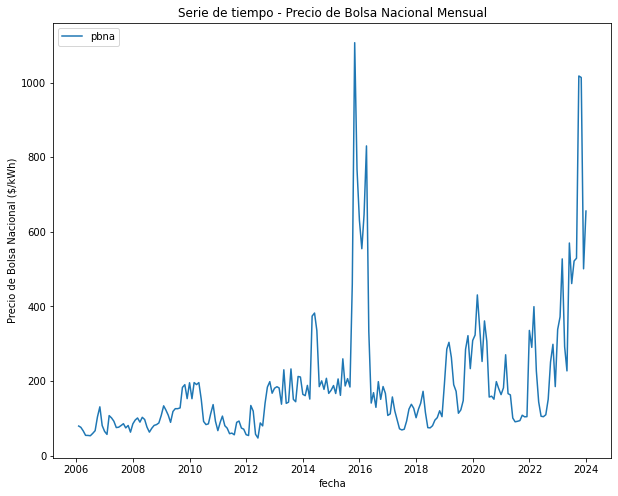

In [9]:
# gráficando la serie de tiempo

# creando lienzo
plt.figure(figsize=(10,8))

# creando gráfico de serie de tiempo
plt.plot(df_vcm['fechaoperacion'],df_vcm['valor'],label='pbna')

# creando los titulos
plt.xlabel('fecha')
plt.ylabel('Precio de Bolsa Nacional ($/kWh)')
plt.title('Serie de tiempo - Precio de Bolsa Nacional Mensual')
plt.legend(loc='upper left')

# mostrando gráfico
plt.show()

**3. Cálculo del Promedio Móvil**

En esta sección, procedemos a calcular el promedio móvil de la serie temporal para analizar su comportamiento. Inicialmente, vamos a crear el promedio móvil de los últimos tres meses para observar cómo afecta esto a la gráfica. Los pasos realizados son los siguientes:

- Realización del Promedio Móvil:
Utilizando la función de promedio móvil, calculamos la media de los últimos tres meses de la serie temporal. Este proceso implica suavizar los datos al calcular el promedio de un intervalo móvil de tamaño predefinido.
- Creación del Promedio Móvil de los Últimos Tres Meses:
Se crea una nueva columna en el dataframe llamada "ma3", donde se almacena el promedio móvil de los últimos tres meses de la serie temporal. Para ello, se utiliza el método rolling junto con la función mean() y se desplaza un período hacia adelante utilizando shift(1) para evitar la contaminación de datos.
- Visualización del Dataframe con el Promedio Móvil:
Mostramos las primeras diez filas del dataframe que ahora incluye la columna de promedio móvil. Esto nos permite inspeccionar cómo se han modificado los datos con la aplicación del promedio móvil y prepararnos para visualizar los resultados en la gráfica.

In [10]:
# realizando el promedio movil de la serie de tiempo

#  realizando el promedio movil de los ultimos tres meses
df_vcm['ma3'] = df_vcm['valor'].rolling(window=3).mean().shift(1)

# monstrando el dataframe con el promedio movil
df_vcm.head(10)


,fechaoperacion,valor,ma3
0,2006-01-31,79.026486,NaN
1,2006-02-28,75.520919,NaN
2,2006-03-31,65.787447,NaN
3,2006-04-30,54.012347,73.444951
4,2006-05-31,53.819582,65.106905
5,2006-06-30,52.985621,57.873125
6,2006-07-31,59.316403,53.605850
7,2006-08-31,66.532754,55.373868
8,2006-09-30,103.448612,59.611592
9,2006-10-31,130.511701,76.432590


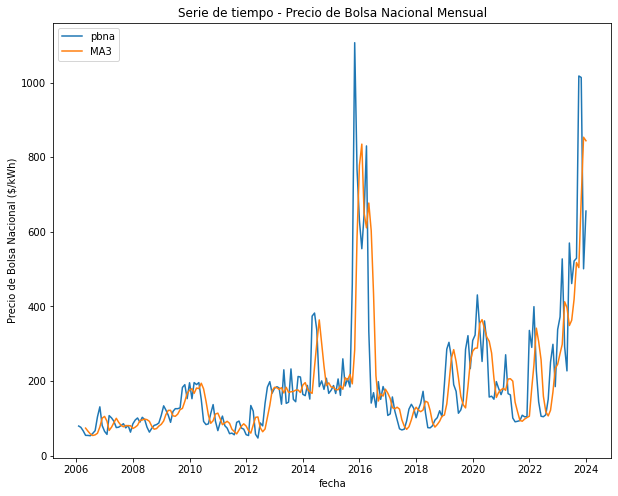

In [11]:
# gráficando la serie de tiempo

# creando lienzo
plt.figure(figsize=(10,8))

# creando gráfico de serie de tiempo
plt.plot(df_vcm['fechaoperacion'],df_vcm['valor'],label='pbna')
plt.plot(df_vcm['fechaoperacion'],df_vcm['ma3'],label='MA3')

# creando los titulos
plt.xlabel('fecha')
plt.ylabel('Precio de Bolsa Nacional ($/kWh)')
plt.title('Serie de tiempo - Precio de Bolsa Nacional Mensual')
plt.legend(loc='upper left')

# mostrando gráfico
plt.show()

Tras examinar el resultado de la media móvil con un período de tres meses, se puede observar una similitud notable con la gráfica original de la serie temporal. Este hallazgo sugiere que la media móvil con n=3 está altamente influenciada por la variabilidad aleatoria presente en los datos.

Por lo tanto, resulta evidente la necesidad de explorar valores de períodos de media móvil más amplios para obtener una comprensión más precisa de las tendencias subyacentes en la serie temporal. Se recomienda analizar valores de medias móviles más altos, como seis, nueve y doce meses, para su evaluación. Estos períodos más extensos pueden proporcionar una perspectiva más robusta de las tendencias a largo plazo y ayudar a mitigar la influencia de la variabilidad aleatoria en el análisis de la serie temporal

In [12]:
# realizando el promedio movil de la serie de tiempo

#  realizando el promedio movil de los ultimos tres meses
df_vcm['ma6'] = df_vcm['valor'].rolling(window=6).mean().shift(1)
df_vcm['ma9'] = df_vcm['valor'].rolling(window=9).mean().shift(1)
df_vcm['ma12'] = df_vcm['valor'].rolling(window=12).mean().shift(1)

# monstrando el dataframe con el promedio movil
df_vcm.head(15)

,fechaoperacion,valor,ma3,ma6,ma9,ma12
0,2006-01-31,79.026486,NaN,NaN,NaN,NaN
1,2006-02-28,75.520919,NaN,NaN,NaN,NaN
2,2006-03-31,65.787447,NaN,NaN,NaN,NaN
3,2006-04-30,54.012347,73.444951,NaN,NaN,NaN
4,2006-05-31,53.819582,65.106905,NaN,NaN,NaN
5,2006-06-30,52.985621,57.873125,NaN,NaN,NaN
6,2006-07-31,59.316403,53.605850,63.525400,NaN,NaN
7,2006-08-31,66.532754,55.373868,60.240386,NaN,NaN
8,2006-09-30,103.448612,59.611592,58.742359,NaN,NaN
9,2006-10-31,130.511701,76.432590,65.019220,67.827797,NaN


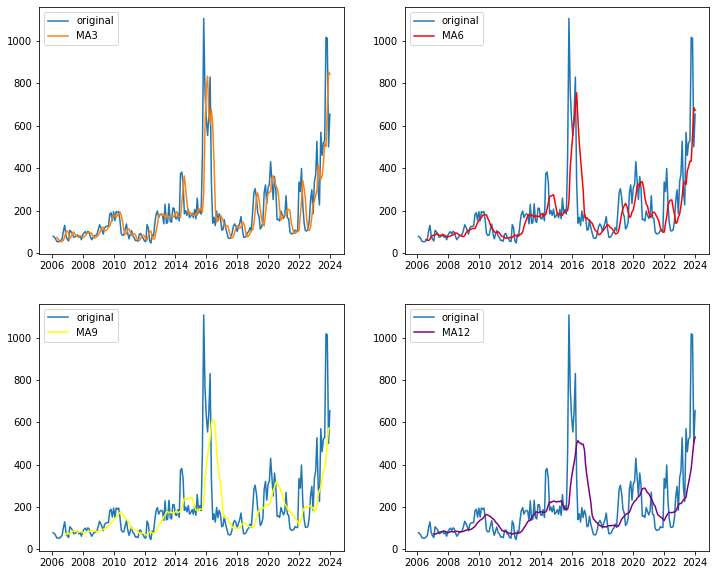

In [19]:
# gráficando la serie de tiempo

# creando lienzo
plt.figure(figsize=(12,10))

# creando gráfico de serie de tiempo
plt.subplot(2,2,1)
plt.plot(df_vcm['fechaoperacion'],df_vcm['valor'],label='original')
plt.plot(df_vcm['fechaoperacion'],df_vcm['ma3'],label='MA3')
plt.legend(loc='upper left')

plt.subplot(2,2,2)
plt.plot(df_vcm['fechaoperacion'],df_vcm['valor'],label='original')
plt.plot(df_vcm['fechaoperacion'],df_vcm['ma6'],label='MA6',color='red')
plt.legend(loc='upper left')

plt.subplot(2,2,3)
plt.plot(df_vcm['fechaoperacion'],df_vcm['valor'],label='original')
plt.plot(df_vcm['fechaoperacion'],df_vcm['ma9'],label='MA9',color='yellow')
plt.legend(loc='upper left')

plt.subplot(2,2,4)
plt.plot(df_vcm['fechaoperacion'],df_vcm['valor'],label='original')
plt.plot(df_vcm['fechaoperacion'],df_vcm['ma12'],label='MA12',color='purple')
plt.legend(loc='upper left')

# mostrando gráfico
plt.show()

**4. Resultados**

Después de analizar detenidamente las medias móviles con diferentes valores de n (n=3, 6, 9 y 12), se pueden extraer varias conclusiones significativas:

- Tendencias Identificadas:
Al observar las gráficas generadas para cada media móvil, se destaca la presencia de picos pronunciados en los años 2015 y 2017, así como en el año 2024. Estos picos podrían indicar períodos de cambios significativos en la serie temporal, lo que podría ser de interés para un análisis más detallado.
- Suavizado de las Líneas:
Se observa claramente que a medida que el valor de n aumenta en la media móvil, las líneas generadas se vuelven más suaves. Este suavizado es una característica importante de las medias móviles con valores de n más altos, ya que ayuda a eliminar el ruido o la variabilidad aleatoria de los datos, permitiendo así una visualización más clara de las tendencias subyacentes.
- Reducción de los Picos:
Otra observación relevante es que a medida que el valor de n aumenta, los picos en las gráficas de las medias móviles tienden a ser menos pronunciados. Esto sugiere que las medias móviles con valores de n más altos tienen una capacidad reducida para capturar fluctuaciones abruptas en los datos, lo que las hace más adecuadas para identificar tendencias a largo plazo en lugar de cambios repentinos.
- Sensibilidad a los Datos Aleatorios:
Se destaca que las medias móviles con valores de n más altos tienden a ser menos sensibles a los efectos de los datos aleatorios. Esto implica que las predicciones basadas en medias móviles con valores de n más altos tendrán una fluctuación más lenta ante cambios en los períodos más recientes de la serie temporal. Esta característica es crucial para generar pronósticos más estables y confiables, especialmente en entornos con datos volátiles o ruidosos.

### 2.2.3 Análisis de rezagos

En esta sección, exploramos la importancia del análisis de rezagos para identificar relaciones temporales entre puntos de datos consecutivos en una serie temporal. Este análisis nos permite comprender más profundamente la dinámica subyacente de la serie temporal y desvelar posibles patrones de comportamiento. Para realizar este análisis, llevamos a cabo los siguientes pasos:

- Creación de una Función para Graficar los Rezagos del Dataset:
Implementamos una función para visualizar los rezagos en el conjunto de datos. Esta función nos permite examinar cómo se relacionan los valores en diferentes puntos temporales, revelando posibles correlaciones y patrones de comportamiento en la serie temporal.

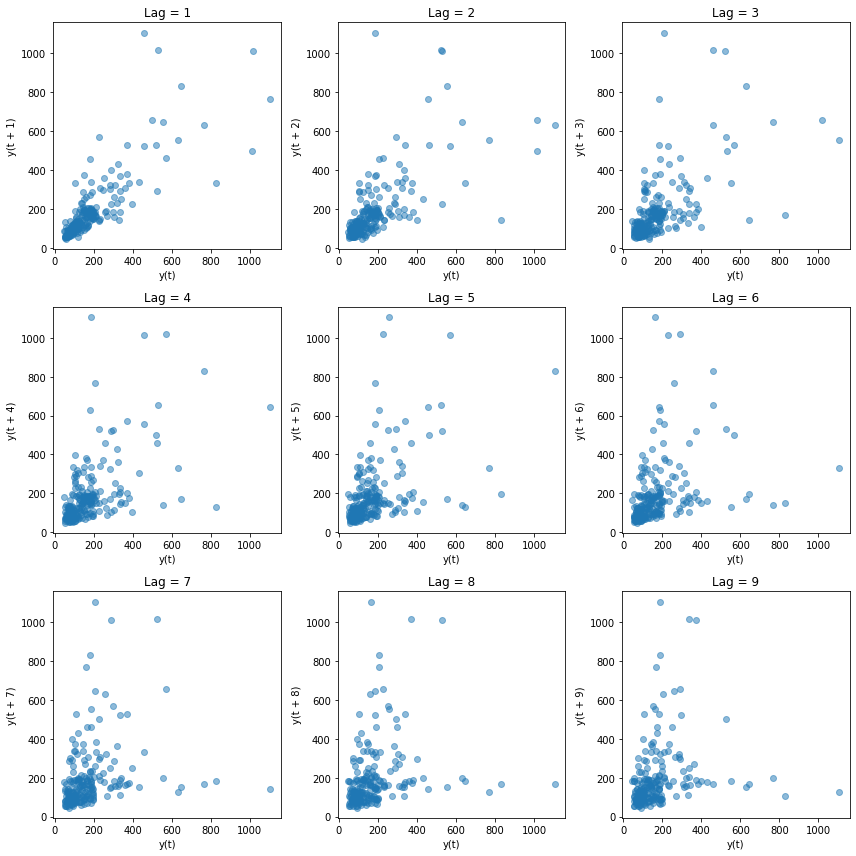

In [20]:
# Creando función para gráficar los rezagos del dataset

# Crear un panel de gráficos 3x3
fig, axes = plt.subplots(3, 3, figsize=(12, 12))

# Iterar sobre las filas y columnas del panel
for i in range(3):
    for j in range(3):
        lag = i * 3 + j + 1  # Calcular el lag correspondiente
        ax = axes[i, j]  # Obtener el eje actual
        
        # Calcular y graficar el lag plot con el lag actual
        ax.plot(df_vcm['valor'][:-lag], df_vcm['valor'][lag:], 'o', alpha=0.5)
        ax.set_title(f'Lag = {lag}')
        ax.set_xlabel('y(t)')
        ax.set_ylabel(f'y(t + {lag})')

# Ajustar el espaciado entre los subplots
plt.tight_layout()
plt.show()

- De las graficas de rezagos no existe un patron de distancia que pueda determinar que exista estacionalidad. Los puntos siempre se mueven de alguna manera en cada uno de los rezagos.
- Es necesario contar con analisis de disintos intervalos de tiempo para determinar si presenta estacionalidad o no.

### 2.2.3 Análisis de estacionalidad

En esta sección, nos adentramos en el análisis de la estacionalidad de la serie temporal. La estacionalidad es un componente clave que revela patrones recurrentes o ciclos en los datos a lo largo del tiempo, lo que resulta fundamental para comprender su comportamiento a largo plazo. Para llevar a cabo este análisis, seguimos los siguientes pasos:

**1. Descomposición Estacional de la Serie Temporal**

Utilizamos el método de descomposición estacional para separar la serie temporal en sus componentes principales: tendencia, estacionalidad y residuo. Este proceso nos permite identificar y analizar cada componente por separado, lo que facilita la comprensión de la dinámica subyacente de la serie temporal.

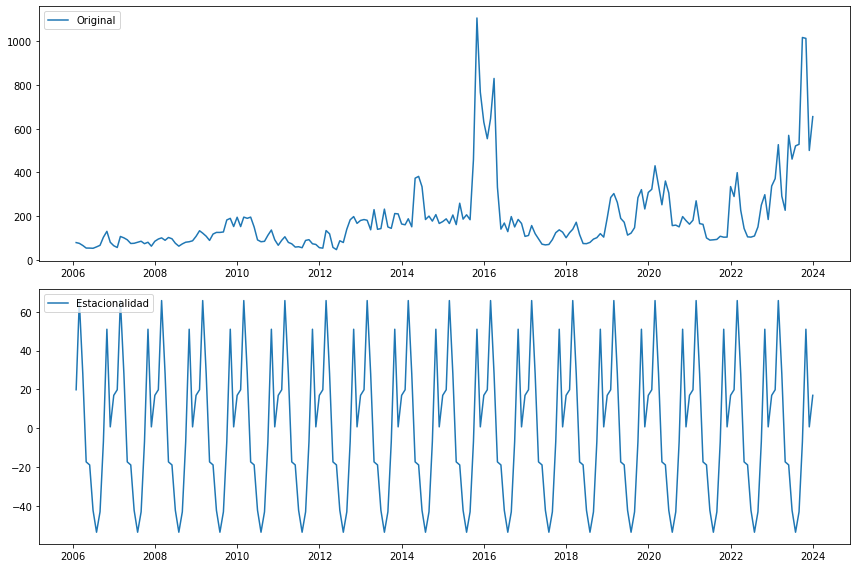

In [21]:
# Establecer 'fechaoperacion' como el índice del DataFrame
df_vcm.set_index('fechaoperacion', inplace=True)

# Asegúrate de que la frecuencia esté definida (por ejemplo, mensual 'M')
df_vcm.index.freq = 'M'

# Realizar la descomposición estacional de la serie temporal
result = seasonal_decompose(df_vcm['valor'], model='additive')

# Graficar la serie original, la tendencia, la estacionalidad y el residuo
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(df_vcm['valor'], label='Original')
plt.legend(loc='upper left')

plt.subplot(2, 1, 2)
plt.plot(result.seasonal, label='Estacionalidad')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

**2. Resultados**

Tras examinar los resultados del análisis de estacionalidad, se revelan hallazgos que requieren una comprensión más profunda y una evaluación cuidadosa. Al respecto:

- Patrones Mensuales Identificados:
El análisis de estacionalidad revela la presencia de un patrón recurrente que se repite mensualmente en los datos. Esta observación es fundamental, ya que sugiere la existencia de fluctuaciones predecibles en los valores de la serie temporal en intervalos regulares de tiempo. Sin embargo, es importante destacar que este hallazgo puede parecer contradictorio con las observaciones derivadas del análisis de rezagos y la evaluación de la tendencia.
- Contrastes con los Análisis de Rezagos y Tendencia:
Al contrastar los resultados del análisis de estacionalidad con los patrones identificados en el análisis de rezagos y la evaluación de la tendencia, se observan discrepancias significativas. Mientras que el análisis de rezagos y la evaluación de la tendencia no revelan claramente la presencia de un patrón o ciclo en los datos a lo largo del tiempo, el análisis de estacionalidad destaca la existencia de un patrón mensual distintivo. Esta discrepancia plantea interrogantes sobre la consistencia y la interpretación de los resultados obtenidos en diferentes análisis temporales.
- Necesidad de Análisis en Diferentes Intervalos de Tiempo:
Ante la presencia de resultados divergentes, se hace evidente la necesidad de realizar análisis en diferentes intervalos de tiempo para determinar de manera más precisa si la serie temporal presenta estacionalidad o no. La exploración de patrones estacionales en intervalos de tiempo más amplios podría proporcionar una visión más completa y matizada de la dinámica temporal de los datos, permitiendo así una interpretación más precisa de su comportamiento a lo largo del tiempo.